# Investigating well position effect
**Author:** Jessica Ewald <br>

The purpose of this notebook is to quantify well position effect using two plates with 48X repeated ALK WT and one ALK VAR (a positive control). Previously, classifiers were constructed between cells in each WT versus each VAR well pair, between each possible pair of VAR wells and each possible pair of WT pairs. The WT-WT and VAR-VAR comparisons can be interrogated to get an estimate of well position effect across different positions. The WT-VAR comparisons will give an idea of the size of the morphological perturbation relative to the well position effect. 

In [23]:
# Imports
import pathlib
import polars as pl
import pandas as pd
import numpy as np
from scipy import stats
import os

import black
import jupyter_black

jupyter_black.load(
    lab=False,
    line_length=79,
    verbosity="DEBUG",
    target_version=black.TargetVersion.PY310,
)

import warnings
warnings.filterwarnings("ignore")

In [2]:
result_dir = pathlib.Path(f'/dgx1nas1/storage/data/jess/varchamp/sc_data/classification_results/B4A3R1/ALK_WT_VAR')
files = os.listdir(result_dir)
files

['B4A3R1_non_protein_REF_control_feat_importance_normalized_feature_selected.csv',
 'B4A3R1_well_distances.csv',
 'B4A3R1_non_protein_feat_importance_normalized_feature_selected.csv',
 'B4A3R1_protein_VAR_control_feat_importance_normalized_feature_selected.csv',
 'B4A3R1_non_protein_VAR_control_feat_importance_normalized_feature_selected.csv',
 'B4A3R1_non_protein_REF_control_f1score_normalized_feature_selected.csv',
 'B4A3R1_non_protein_VAR_control_f1score_normalized_feature_selected.csv',
 'B4A3R1_protein_REF_control_feat_importance_normalized_feature_selected.csv',
 'B4A3R1_protein_REF_control_f1score_normalized_feature_selected.csv',
 'B4A3R1_protein_VAR_control_f1score_normalized_feature_selected.csv',
 'B4A3R1_non_protein_f1score_normalized_feature_selected.csv',
 'B4A3R1_protein_f1score_normalized_feature_selected.csv',
 'B4A3R1_protein_feat_importance_normalized_feature_selected.csv']

In [3]:
df = pd.read_csv(f'{result_dir}/{files[10]}')

From a quick examination of the results, we see that cells in all pairs of wells are almost perfectly separable. Since the signal detected by our classifier is saturated, we will have to either make the classification task more difficult, or compute distance in some other way (perhaps directly: Euclidean, cosine, etc, with and without PCA transformation). That way we can at least assess the well position effect relative to the genetic perturbation.

But first, let's look at the variable importance scores to understand which features are driving the classifiers. Answer questions:

1. Within the same comparisons (WT-WT, VAR-VAR, WT-VAR), is there consistency in the important features?
2. If there is consistency, how do the important features vary between each of the three cases mentioned above? 
3. If the same features are always used, even the WT-VAR classifiers are likely learning well position effect instead of morphology effect. If we do a training strategy closer to our actual analysis, do the classifiers learn to place importance on other features? (Ie. train with 3 WT and 3 VAR wells, test on two other wells).

In [15]:
# Read in all variable feature importance scores
batch = 'B4A3R1'
feature_sets = ['non_protein', 'protein']
comparisons = ['REF_control_feat_importance', 'VAR_control_feat_importance', 'feat_importance']
comp_dict = {'REF_control_feat_importance': 'REF_REF',
             'VAR_control_feat_importance': 'VAR_VAR',
             'feat_importance': 'REF_VAR'}

feat_imp = pl.DataFrame()
for fs in feature_sets:
    for comp in comparisons:
        
        df = pl.read_csv(f'{result_dir}/{batch}_{fs}_{comp}_normalized_feature_selected.csv')
        
        if "Reference_Well" in df.columns:
            df = df.rename({"Reference_Well": "Well_One", "Variant_Well": "Well_Two"})
            
        df = df.melt(id_vars = ['Well_One', 'Well_Two']).with_columns(pl.lit(fs).alias("Feature_Set"),
                                                                      pl.lit(comp_dict[comp]).alias('Comparison'),
                                                                      pl.lit(batch).alias('Batch'))
        feat_imp = pl.concat([feat_imp, df], how = "vertical")

In [39]:
len(feat_imp.select(pl.col("ClassifierID")).unique())/2

4560.0

In [16]:
# Add unique identifier
feat_imp = feat_imp.with_columns(pl.concat_str([pl.col("Well_One"), pl.col("Well_Two"), pl.col("Feature_Set"), pl.col("Comparison")], separator="_").alias("ClassifierID"))
#feat_imp = feat_imp.filter(pl.col("value") > 0)

In [17]:
# Add rank of feature within each classifier
feat_imp = feat_imp.with_columns(pl.col("value").rank(descending=True).over("ClassifierID").alias("FIP_rank"))

In [20]:
# summarize ranks

imp_summary = feat_imp.group_by(["variable", "Feature_Set", "Comparison"]).agg(pl.col("FIP_rank").mean().alias("mean_VIP"))

In [22]:
# Do features have similar importance across comparisons?

prot_summary = imp_summary.filter(pl.col("Feature_Set") == "protein").pivot(index="variable", columns="Comparison", values="mean_VIP")


In [24]:
cor_ref_var = stats.pearsonr(prot_summary[["REF_REF"]].to_series(), prot_summary[["VAR_VAR"]].to_series())
cor_ref_diff = stats.pearsonr(prot_summary[["REF_REF"]].to_series(), prot_summary[["REF_VAR"]].to_series())
cor_diff_var = stats.pearsonr(prot_summary[["REF_VAR"]].to_series(), prot_summary[["VAR_VAR"]].to_series())

In [25]:
print(cor_ref_var)
print(cor_ref_diff)
print(cor_diff_var)

PearsonRResult(statistic=0.9695669971830727, pvalue=9.428961318280282e-163)
PearsonRResult(statistic=0.9893170185274877, pvalue=5.608084275035123e-222)
PearsonRResult(statistic=0.975381506325411, pvalue=1.0746810420331487e-174)


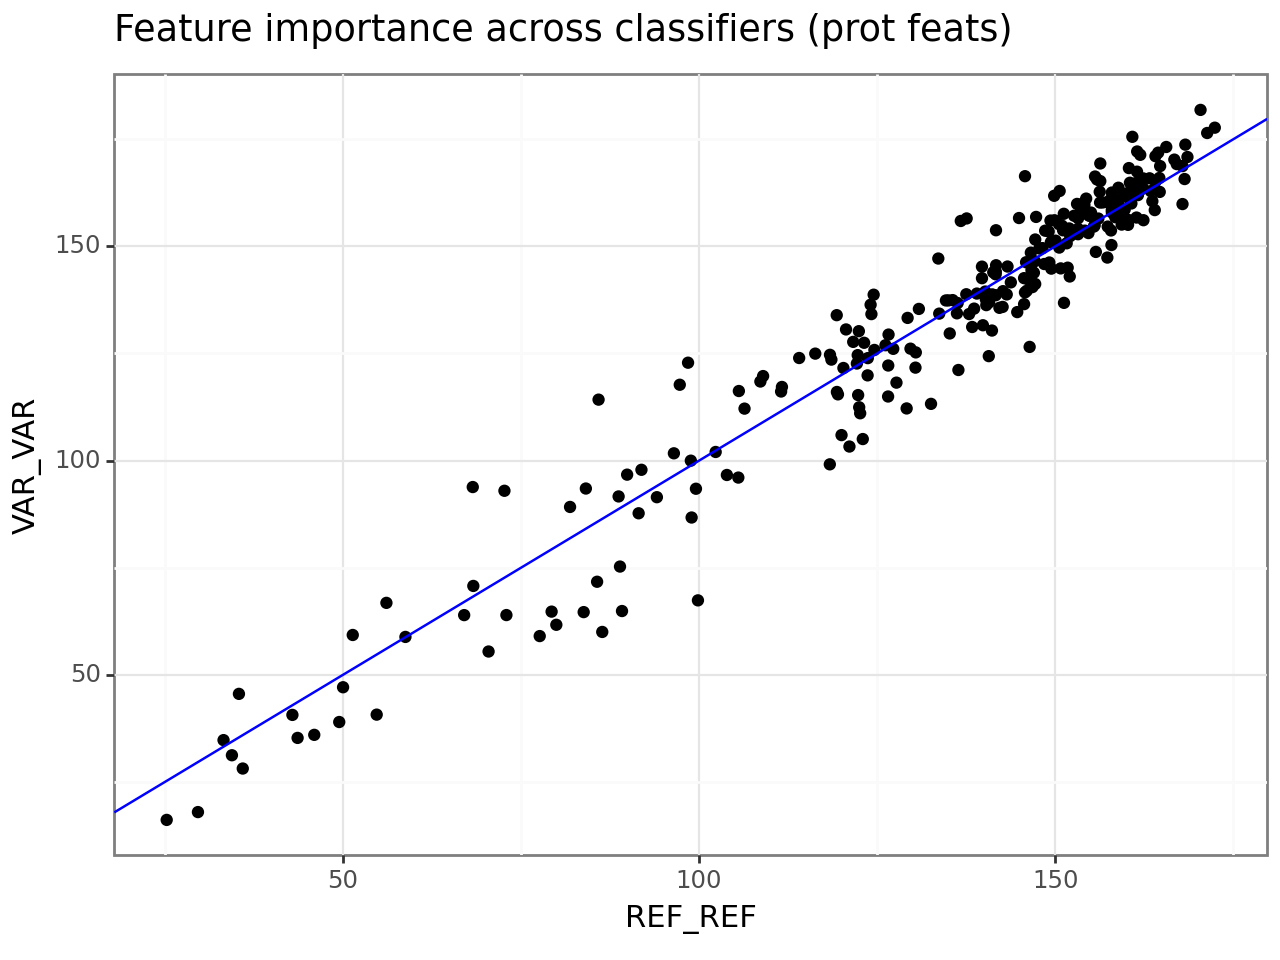

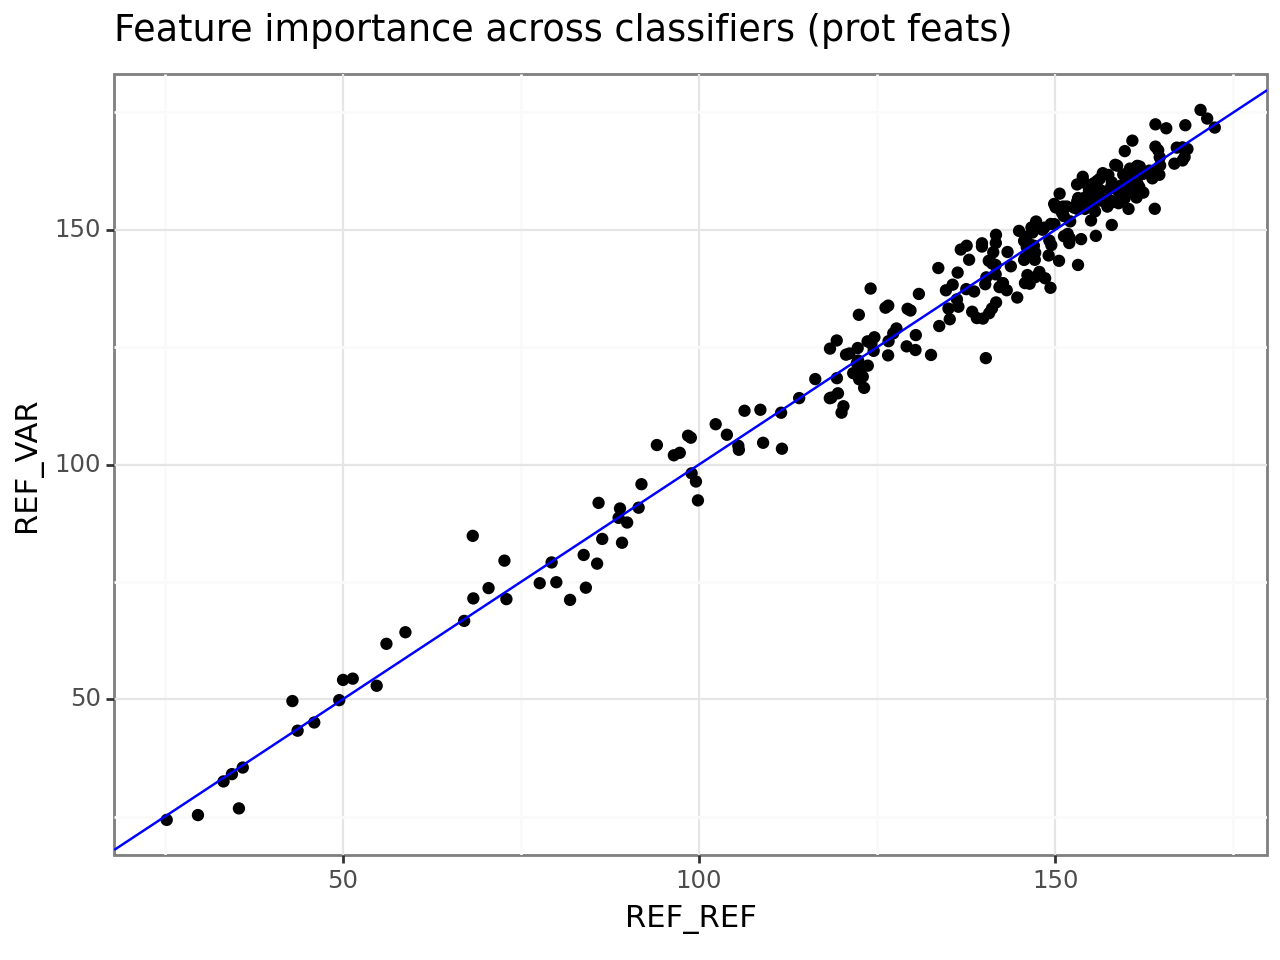

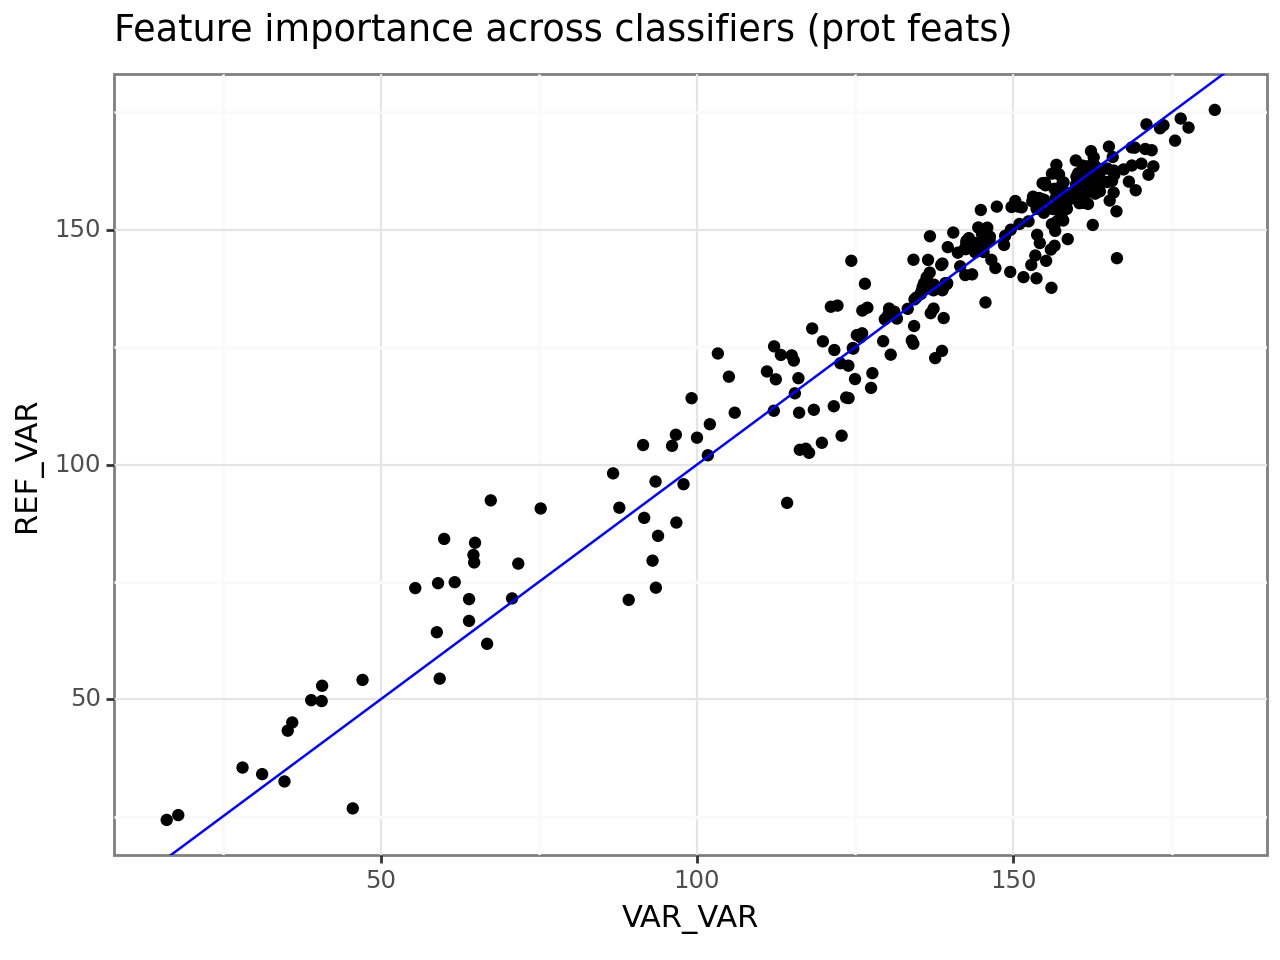

In [37]:
from plotnine import ggplot, aes, geom_point, theme_bw, geom_abline, ggtitle
p1 = (ggplot(prot_summary)
         + aes(x = "REF_REF", y = "VAR_VAR")
         + geom_point() + geom_abline(slope=1, intercept = 0, colour = 'blue') 
         + ggtitle("Feature importance across classifiers (prot feats)")
         + theme_bw())
print(p1)

p2 = (ggplot(prot_summary)
         + aes(x = "REF_REF", y = "REF_VAR")
         + geom_point() + geom_abline(slope=1, intercept = 0, colour = 'blue') 
         + ggtitle("Feature importance across classifiers (prot feats)")
         + theme_bw())
print(p2)

p3 = (ggplot(prot_summary)
         + aes(x = "VAR_VAR", y = "REF_VAR")
         + geom_point() + geom_abline(slope=1, intercept = 0, colour = 'blue') 
         + ggtitle("Feature importance across classifiers (prot feats)")
         + theme_bw())
print(p3)

The answers seem to be that in all cases (REF-REF, VAR-VAR, REF-VAR), the same features are used to build the classifiers. Widespread differences between wells are more easily learned than differences in morphology. 

Next, I'll check to see if the well position itself is repeatable. In other words, does each specific well position have a unique signature that can be predicted on new data, or does each well generally have a unique signature? I can assess this by training models between two wells on one plate, and testing performance using the same two wells but on the other plate. 

If we have really good performance, then that's bad: a position-specific effect that is highly repeatable across plates. 

If the classifiers do not perform well ever (even for REF-VAR), it's likely that there are not repeatable position-specific effects. Since the classifiers highly focus on the few features that distinguish wells on one plate, they are missing out on learning perturbation-specific morphological differences. In our real data there are four replicates and so we can train on three plates and test on one. Here we can't do that since there are only two replicates, but the next best thing is to just concatenate cells from both plates, shuffle rows, and train a model like we did for the first set of results presented above. 

Therefore, next I will train two more sets of classifiers:

1. Train with cells from two wells on one plate and assess performance using cells from the same two wells on the other plate (external test set).
2. Concatenate data from both plates. Train between two well on one plate and assess performance using cross-validation.